# TEO Simulation in PyBullet

This notebook contains an example using pybullet to perform a stability test. We will first load the robot in its initial position, enable position control and simulate for a few seconds to correct for the ability of the robot to mantain the position. Then a joint/torque sensor will be aded to the ankle to measeure the ground reaction as it performs a movement.

## Setup

Import the necesary libraries

In [20]:
import pybullet as p
import numpy as np
import pybullet_data
import time
from math import radians, degrees
import os, inspect
currentdir = !pwd 
currentdir = currentdir[0]
parentdir = os.path.dirname(currentdir)
urdf_root = os.path.join(parentdir,"bullet")

Start the physics client in Graphic mode

In [21]:
physicsClient = p.connect(p.GUI)

error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

Add path for PyBullet exaples and useful assets such as the ground plane 

In [22]:
p.setAdditionalSearchPath(pybullet_data.getDataPath())

Set the gravity

In [23]:
p.setGravity(0,0,-9.79983)

Load the ground

In [24]:
planeId = p.loadURDF("plane.urdf")

Load the TEO urdf file above the ground plane

In [25]:
teoStartOrientation = p.getQuaternionFromEuler([0,0,0])
teoStartPosition = [0,0,0.820932]
urdf_path = os.path.join(urdf_root,"TEO.urdf")
teoId = p.loadURDF(urdf_path,teoStartPosition ,teoStartOrientation)
jointPositions=[ 0.000749, 0.001018, 0.000723, 0.000542, 0.000637, 0.262536, 0.000736, 0.000747, 0.000727, 0.000729, 0.000832, -0.086529, 0.000735, 0.000733, 0.000727, 0.000730, 0.000897, 0.262507, 0.000724, 0.000408, 0.000791, -0.260378, 0.000000, 0.000660, 0.210138, -0.400503, 0.803548, -0.313384, -0.208710, 0.000000]
for jointIndex in range (p.getNumJoints(teoId)):
    p.resetJointState(teoId,jointIndex,jointPositions[jointIndex])


In [26]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
urdf_root = os.path.join(parentdir,"models")
urdf_root

'/tmp/models'

If loaded correctly we should see all the joint names and their joint ids

In [28]:
n_joints = p.getNumJoints(teoId)
p.getNumJoints(teoId)

for i in range(n_joints):
    print(p.getJointInfo(teoId,i)[1],i)

b'waist_yaw' 0
b'waist_pitch' 1
b'head_yaw' 2
b'head_pitch' 3
b'l_shoulder_pitch' 4
b'l_shoulder_roll' 5
b'l_shoulder_yaw' 6
b'l_elbow_pitch' 7
b'l_wrist_yaw' 8
b'l_wrist_pitch' 9
b'r_shoulder_pitch' 10
b'r_shoulder_roll' 11
b'r_shoulder_yaw' 12
b'r_elbow_pitch' 13
b'r_wrist_yaw' 14
b'r_wrist_pitch' 15
b'l_hip_yaw' 16
b'l_hip_roll' 17
b'l_hip_pitch' 18
b'l_knee_pitch' 19
b'l_ankle_pitch' 20
b'l_ankle_roll' 21
b'l_sole_joint' 22
b'r_hip_yaw' 23
b'r_hip_roll' 24
b'r_hip_pitch' 25
b'r_knee_pitch' 26
b'r_ankle_pitch' 27
b'r_ankle_roll' 28
b'r_sole_joint' 29


### Define starting position

We set the desired joint positions for the joint controllers to achieve. We also set the max force to the ones defined by the urdf and the max velocities to what we desire.

In [29]:
n_joints = p.getNumJoints(teoId)

jointIndices = [0] * n_joints
targetPos = [0.0] * n_joints
maxVelocities = [radians(1)] * n_joints
maxForces = [0.0] * n_joints


for i in range(n_joints):
    jointIndices[i] = i
    maxForces[i] = p.getJointInfo(teoId,i)[10]
    
    
    if p.getJointInfo(teoId,i)[1] == 'waist_yaw':
        targetPos[i] = 0
    elif p.getJointInfo(teoId,i)[1] == 'r_shoulder_roll':
        targetPos[i] = radians(-5)
        
    elif p.getJointInfo(teoId,i)[1] == 'r_hip_roll':
        targetPos[i] = radians(12)
    elif p.getJointInfo(teoId,i)[1] == 'r_hip_pitch':
        targetPos[i] = radians(-23)
    elif p.getJointInfo(teoId,i)[1] == 'r_knee_pitch':
        targetPos[i] = radians(46)
    elif p.getJointInfo(teoId,i)[1] == 'r_ankle_pitch':
        targetPos[i] = radians(-23)
    elif p.getJointInfo(teoId,i)[1] == 'r_ankle_roll':
        targetPos[i] = radians(-12)
        
    elif p.getJointInfo(teoId,i)[1] == 'l_hip_roll':
        targetPos[i] = radians(15)
        maxForces[i] = 60
    elif p.getJointInfo(teoId,i)[1] == 'l_ankle_roll':
        targetPos[i] = radians(-15)
        
    elif p.getJointInfo(teoId,i)[1] == 'l_shoulder_roll':
        targetPos[i] = radians(15)
    else:
        targetPos[i] = 0
        

We set the joint control with the created arrays and set it to position control.

In [30]:
mode = p.POSITION_CONTROL

p.setJointMotorControlArray(teoId,
                            jointIndices, 
                            controlMode=mode,
                            forces=maxForces,
                            targetVelocities = maxVelocities,
                            targetPositions = targetPos
                           )

Advance simulation until the robot is stable

In [31]:
for i in range (3000):
    p.stepSimulation()
    time.sleep(1./240.)

### Begin the Experiment

Create a joint/force sensor in the ankle and save the result at each simulation step.

In [12]:
waistId = 0
shoulderId = 11
soleId = 22

exp_joints = [waistId, shoulderId]

expMaxPos = [radians(45), radians(-50)] 
expVelocities = [radians(15),radians(-15)]
expMaxForces =[p.getJointInfo(teoId,waistId)[10],p.getJointInfo(teoId,waistId)[10]]

mode = p.VELOCITY_CONTROL
        
p.setJointMotorControlArray(teoId,
                            exp_joints, 
                            controlMode=mode,
                            forces=expMaxForces,
                            targetVelocities = expVelocities,
                            targetPositions = expMaxPos
                           )
p.enableJointForceTorqueSensor(teoId, soleId, 1)

In [15]:
timesteps = 3000
results = np.zeros((timesteps,6))


for i in range(timesteps):
    p.stepSimulation()
    data = list(zip(*p.getJointStates(teoId,[waistId, shoulderId, soleId])))
    results[i]=np.asarray([time.time(), degrees(data[0][0]),degrees(data[0][1]), data[2][2][2], data[2][2][3],data[2][2][4]])
    time.sleep(1./240.)


In [16]:
np.savetxt("bullet_test.csv", results, delimiter=",")

### Visualize results

In [17]:
import matplotlib.pyplot as plt
import csv

In [19]:
import pandas as pd

In [20]:
experiment = pd.read_csv('bullet_test.csv',index_col=0)

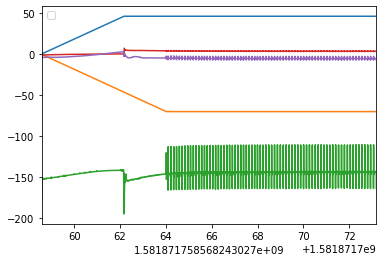

In [25]:
plot = experiment.plot()
plot.legend('')